# Implementation of Softmax Regression from Scratch

:label:`chapter_softmax_scratch`


Just as we implemented linear regression from scratch,
we believe that multiclass logistic (softmax) regression
is similarly fundamental and you ought to know
the gory details of how to implement it from scratch.
As with linear regression, after doing things by hand
we will breeze through an implementation in Gluon for comparison.
To begin, let's import our packages.

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
import torch
from torch.distributions import normal

We will work with the Fashion-MNIST dataset just introduced,
cuing up an iterator with batch size 256.

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initialize Model Parameters

Just as in linear regression, we represent each example as a vector.
Since each example is a $28 \times 28$ image,
we can flatten each example, treating them as $784$ dimensional vectors.
In the future, we'll talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are categories.
Because our dataset has $10$ categories,
our network will have an output dimension of $10$.
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ vector.
As with linear regression, we will initialize our weights $W$
with Gaussian noise and our biases to take the initial value $0$.

In [3]:
num_inputs = 784
num_outputs = 10

W = normal.Normal(loc = 0, scale = 0.01).sample((num_inputs, num_outputs))
b = torch.zeros(num_outputs)

Recall that we need to *attach gradients* to the model parameters.
More literally, we are allocating memory for future gradients to be stored
and notifiying PyTorch that we want gradients to be calculated with respect to these parameters in the first place.

In [4]:
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## The Softmax

Before implementing the softmax regression model,
let's briefly review how `torch.sum` work
along specific dimensions in a PyTorch tensor.
Given a matrix `X` we can sum over all elements (default) or only
over elements in the same column (`dim=0`) or the same row (`dim=1`).
Note that if `X` is an array with shape `(2, 3)`
and we sum over the columns (`torch.sum(X, dim=0`),
the result will be a (1D) vector with shape `(3,)`.
If we want to keep the number of axes in the original array
(resulting in a 2D array with shape `(1,3)`),
rather than collapsing out the dimension that we summed over
we can specify `keepdim=True` when invoking `torch.sum`.

In [5]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
torch.sum(X, dim=0, keepdim=True), torch.sum(X, dim=1, keepdim=True)

(tensor([[5, 7, 9]]), tensor([[ 6],
         [15]]))

We are now ready to implement the softmax function.
Recall that softmax consists of two steps:
First, we exponentiate each term (using `torch.exp`).
Then, we sum over each row (we have one row per example in the batch)
to get the normalization constants for each example.
Finally, we divide each row by its normalization constant,
ensuring that the result sums to $1$.
Before looking at the code, let's recall
what this looks expressed as an equation:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}
$$

The denominator, or normalization constant,
is also sometimes called the partition function
(and its logarithm the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles).

In [6]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = torch.sum(X_exp, dim=1, keepdim=True)
    return X_exp / partition  # The broadcast mechanism is applied here

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability.
Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because failed to take precautions against numerical overflow or underflow
due to large (or very small) elements of the matrix,
as we did in
:numref:`chapter_naive_bayes`.

In [7]:
# X = nd.random.normal(shape=(2, 5))
X = normal.Normal(loc = 0, scale = 1).sample((2, 5))
X_prob = softmax(X)
X_prob, torch.sum(X_prob, dim=1)

(tensor([[0.0120, 0.0471, 0.3944, 0.3469, 0.1997],
         [0.1948, 0.3007, 0.1048, 0.2569, 0.1427]]), tensor([1., 1.]))

## The Model

Now that we have defined the softmax operation,
we can implement the softmax regression model.
The below code defines the forward pass through the network.
Note that we flatten each original image in the batch
into a vector with length `num_inputs` with the `view` function
before passing the data through our model.

In [8]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

Next, we need to implement the cross entropy loss function,
introduced in :numref:`chapter_softmax`.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.


Recall that cross entropy takes the negative log likelihood
of the predicted probability assigned to the true label $-\log p(y|x)$.
Rather than iterating over the predictions with a Python `for` loop
(which tends to be inefficient), we can use the `gather` function
which allows us to select the appropriate terms
from the matrix of softmax entries easily.
Below, we illustrate the `gather` function on a toy example,
with 3 categories and 2 examples.

In [9]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.tensor([0, 2])
torch.gather(y_hat, 1, y.unsqueeze(dim=1)) # y has to be unsqueezed so that shape(y_hat) = shape(y)

tensor([[0.1000],
        [0.5000]])

Now we can implement the cross-entropy loss function efficiently
with just one line of code.

In [10]:
def cross_entropy(y_hat, y):
    return -torch.gather(y_hat, 1, y.unsqueeze(dim=1)).log()

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with highest predicted probability
whenever we must output a *hard* prediction. Indeed, many applications require that we make a choice. Gmail must catetegorize an email into Primary, Social, Updates, or Forums. It might estimate probabilities internally, but at the end of the day it has to choose one among the categories.

When predictions are consistent with the actual category `y`, they are correct. The classification accuracy is the fraction of all predictions that are correct. Although we cannot optimize accuracy directly (it is not differentiable), it's often the performance metric that we care most about, and we will nearly always report it when training classifiers.

To compute accuracy we do the following:
First, we execute `y_hat.argmax(dim=1)`
to gather the predicted classes
(given by the indices for the largest entires each row).
The result has the same shape as the variable `y`.
Now we just need to check how frequently the two match. The result is PyTorch tensor containing entries of 0 (false) and 1 (true). Since the attribute `mean` can only calculate the mean of floating types,
we also need to convert the result to `float`. Taking the mean yields the desired result.

In [11]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

We will continue to use the variables `y_hat` and `y`
defined in the `gather` function,
as the predicted probability distribution and label, respectively.
We can see that the first example's prediction category is 2
(the largest element of the row is 0.6 with an index of 2),
which is inconsistent with the actual label, 0.
The second example's prediction category is 2
(the largest element of the row is 0.5 with an index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.

In [12]:
accuracy(y_hat, y)

0.5

Similarly, we can evaluate the accuracy for model `net` on the data set
(accessed via `data_iter`).

In [13]:
# The function will be gradually improved: the complete implementation will be
# discussed in the "Image Augmentation" section
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.size()[0]  # y.size()[0] = batch_size
    return acc_sum / n

Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,
i.e. 0.1 for 10 classes.

In [14]:
evaluate_accuracy(test_iter, net)

0.1224

## Model Training

The training loop for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression earlier in this chapter.
Again, we use the mini-batch stochastic gradient descent
to optimize the loss function of the model.
Note that the number of epochs (`num_epochs`),
and learning rate (`lr`) are both adjustable hyper-parameters.
By changing their values, we may be able to increase the classification accuracy of the model. In practice we'll want to split our data three ways
into training, validation, and test data, using the validation data to choose the best values of our hyperparameters.

In [15]:
num_epochs, lr = 5, 0.1

# This function has been saved in the d2l package for future use
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                # This will be illustrated in the next section
                trainer.step(batch_size)
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.size()[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7872, train acc 0.750, test acc 0.793
epoch 2, loss 0.5709, train acc 0.813, test acc 0.806
epoch 3, loss 0.5255, train acc 0.825, test acc 0.813
epoch 4, loss 0.5023, train acc 0.831, test acc 0.825
epoch 5, loss 0.4854, train acc 0.836, test acc 0.827


## Prediction

Now that training is complete, our model is ready to classify some images.
Given a series of images, we will compare their actual labels
(first line of text output) and the model predictions
(second line of text output).

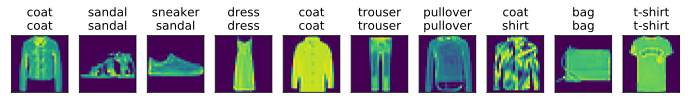

In [16]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[10:20], titles[10:20])

## Summary

With softmax regression, we can train models for multi-category classification. The training loop is very similar to that in linear regression: retrieve and read data, define models and loss functions,
then train models using optimization algorithms. As you'll soon find out, most common deep learning models have similar training procedures.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause (hint - try to calculate the size of $\exp(50)$)?
1. The function `cross_entropy` in this section is implemented according to the definition of the cross-entropy loss function.  What could be the problem with this implementation (hint - consider the domain of the logarithm)?
1. What solutions you can think of to fix the two problems above?
1. Is it always a good idea to return the most likely label. E.g. would you do this for medical diagnosis?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?